# Resources are the end!

# Timing test: Vectorization
You may know by now that you should always prefer vector- or matrix-based operations over for loops, if possible -- you should prefer numpy-array-based operations over for loops. This will also be important for tensorflow -- as much as possible, you should avoid using python for loops when writing tensorflow code. To examine the impact of using for loops over numpy-array-based operations, for this question, you will exploit one of jupyter's built-in magic commands, `%timeit`:

In [1]:
import numpy as np
%timeit np.zeros((100,100))  # provide statistics on how long it takes to generate a 100x100 array of 0s

1.22 µs ± 18.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


As you can see, all you need to do is put `%timeit` before the command that you would normally run and jupyter will run that line multiple times to generate computation timing statistics.

Now, let's compare the computation timing for multiplying two random matrices, each with a dimension of 100x100, using 1) `np.matmul` and 2) multiple embedded for loops. According to `%timeit`, how many times faster is (1) than (2)?

In [2]:
# for loop matrix multiplication
def multiply_matrix(A,B):
    C = np.zeros((A.shape[0],B.shape[1]))
    for row in range(A.shape[0]):
        for col in range(B.shape[1]):
            for elt in range(B.shape[0]):
                C[row, col] += A[row, elt] * B[elt, col]
    return C

In [3]:
A = np.random.random((100,100))
B = np.random.random((100,100))

%timeit A@B

%timeit multiply_matrix(A,B)

156 µs ± 71.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
325 ms ± 2.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Timing test: Convolutions
There are two main ways of computing convolutions digitally: 1) directly, using the definition of a convolution, and 2) using the convolution theorem that you proved in the written portion of the homework assignment (i.e., using ffts). Which method is more efficient depends on the sizes of the inputs. Let's use `%timeit` to compare the speeds for 1D convolutions using [`scipy.signal.convolve `](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html). This function has an argument called "method", which can be set to "direct" or "fft", which correspond to (1) and (2) above. Let's use this function to convolve two random 1D signals of lengths $n=100, 500, 1000,$ and $2000$, and compare the speed of both methods. For which n do(es) method 1 outperform method 2, and vice versa? Can you make any generalizations based on these results about when one method outperforms the other?

In [4]:
from scipy.signal import convolve

# length 100
A = np.random.random(100)
B = np.random.random(100)
%timeit convolve(A, B, mode='same', method='direct')
%timeit convolve(A, B, mode='same', method='fft')

4.21 µs ± 22.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
35.1 µs ± 525 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [5]:
# length 500
A = np.random.random(500)
B = np.random.random(500)
%timeit convolve(A, B, mode='same', method='direct')
%timeit convolve(A, B, mode='same', method='fft')

82.9 µs ± 79.8 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
47 µs ± 197 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [6]:
# length 1000
A = np.random.random(1000)
B = np.random.random(1000)
%timeit convolve(A, B, mode='same', method='direct')
%timeit convolve(A, B, mode='same', method='fft')

380 µs ± 462 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
60.9 µs ± 81.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
# length 2000
A = np.random.random(2000)
B = np.random.random(2000)
%timeit convolve(A, B, mode='same', method='direct')
%timeit convolve(A, B, mode='same', method='fft')

1.69 ms ± 4.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
90.4 µs ± 70.8 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Introductory Image Filtering

Filtering is one of the most basic and common image operations in image processing. You can filter an image to remove noise or to enhance features; the filtered image could be the desired result or just a preprocessing step. Regardless, filtering is an important topic to understand.

In [8]:
#@title Imports
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['image.cmap'] = 'gray'

### Local filtering

The "local" in local filtering simply means that a pixel is adjusted by values in some surrounding neighborhood. These surrounding elements are identified or weighted based on a "footprint", "structuring element", or "kernel".

Let's go to back to basics and look at a 1D step-signal

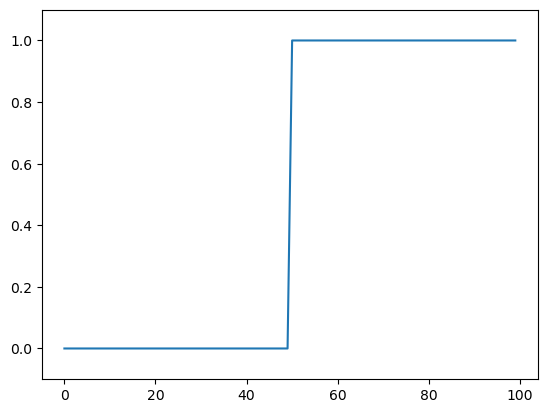

In [9]:
step_signal = np.zeros(100)
step_signal[50:] = 1
fig, ax = plt.subplots()
ax.plot(step_signal)
ax.margins(y=0.1)

Now add some noise to this signal:

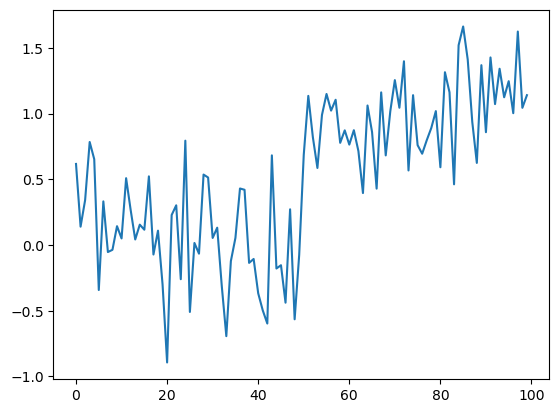

In [10]:
# Just to make sure we all see the same results
np.random.seed(0)

noisy_signal = (step_signal + np.random.normal(0, 0.35, step_signal.shape))
fig, ax = plt.subplots()
ax.plot(noisy_signal); # why semicolon here?
                       # https://stackoverflow.com/questions/51627233/why-is-there-a-semicolon-after-matplotlibs-plot-function

The simplest way to recover something that looks a bit more like the original signal is to take the average between neighboring "pixels":

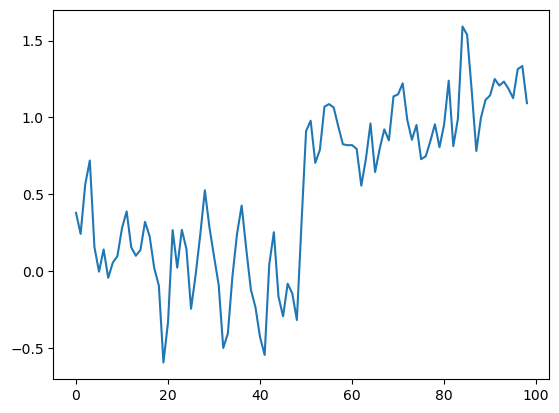

In [11]:
# Take the mean of neighboring pixels
smooth_signal2 = (noisy_signal[:-1] + noisy_signal[1:]) / 2.0
fig, ax = plt.subplots()
ax.plot(smooth_signal2);

What happens if we want to take the *three* neighboring pixels? We can do the same thing:

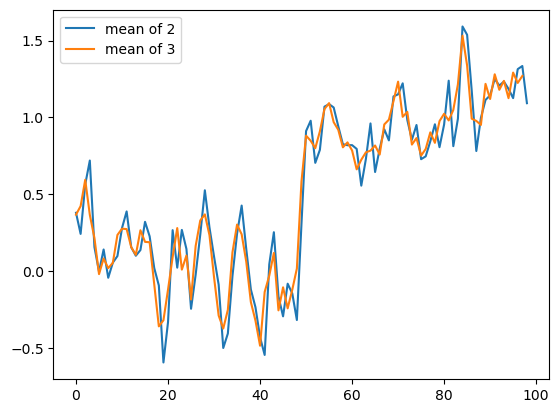

In [12]:
smooth_signal3 = (noisy_signal[:-2] + noisy_signal[1:-1]
                  + noisy_signal[2:]) / 3
fig, ax = plt.subplots()
ax.plot(smooth_signal2, label='mean of 2')
ax.plot(smooth_signal3, label='mean of 3')
ax.legend(loc='upper left');

For averages of more points, the expression keeps getting hairier. And you have to worry more about what's going on in the margins. Is there a better way?

It turns out there is. This same concept, nearest-neighbor averages, can be expressed as a *convolution* with an *averaging kernel*. Note that the operation we did with `smooth_signal3` can be expressed as follows:

* Create an output array called `smooth_signal3p`, of the same length as `noisy_signal`.
* At each element in `smooth_signal3p` starting at point 1 (2nd element), and ending at point -2 (2nd last element), place the average of the sum of: 1/3 of the element to the left of it in `noisy_signal`, 1/3 of the element at the same position, and 1/3 of the element to the right.
* Discard the leftmost and rightmost elements.

This is called a *convolution* between the input image and the array `[1/3, 1/3, 1/3]`. (We'll give a more in-depth explanation of convolution in the next section).

smooth_signal3 and smooth_signal3p are equal: True


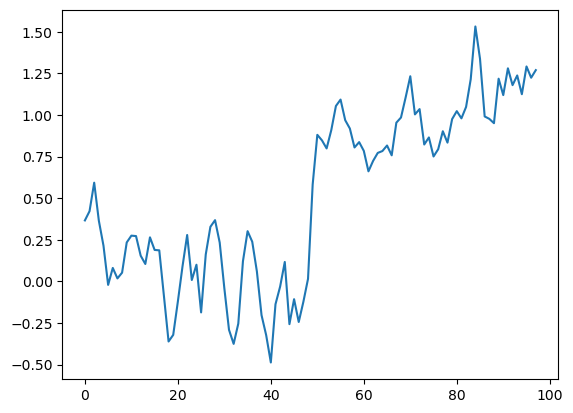

In [13]:
# Same as above, using a convolution kernel
# Neighboring pixels multiplied by 1/3 and summed
mean_kernel3 = np.full((3,), 1/3)
smooth_signal3p = np.convolve(noisy_signal, mean_kernel3,
                              mode='valid')
fig, ax = plt.subplots()
ax.plot(smooth_signal3p)

print('smooth_signal3 and smooth_signal3p are equal:',
      np.allclose(smooth_signal3, smooth_signal3p))

In [14]:
#@title Optional demo, just run the block
def convolve_demo(signal, kernel):
    ksize = len(kernel)
    convolved = np.correlate(signal, kernel)
    def filter_step(i):
        fig, ax = plt.subplots()
        ax.plot(signal, label='signal')
        ax.plot(convolved[:i+1], label='convolved')
        ax.legend()
        ax.scatter(np.arange(i, i+ksize),
                   signal[i : i+ksize])
        ax.scatter(i, convolved[i])
    return filter_step

from ipywidgets import interact, widgets

i_slider = widgets.IntSlider(min=0, max=len(noisy_signal) - 3,
                             value=0)

interact(convolve_demo(noisy_signal, mean_kernel3),
         i=i_slider);

interactive(children=(IntSlider(value=0, description='i', max=97), Output()), _dom_classes=('widget-interact',…

The advantage of convolution is that it's just as easy to take the average of 11 points as 3:

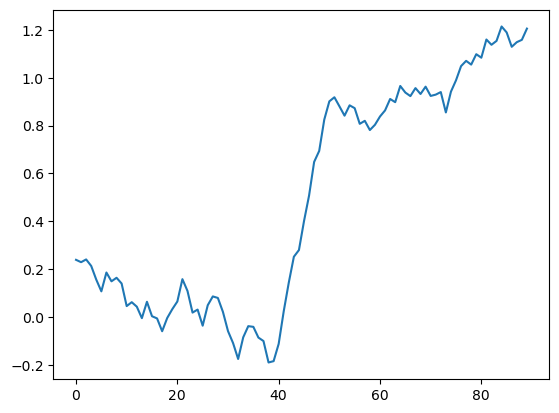

In [15]:
mean_kernel11 = np.full((11,), 1/11)
smooth_signal11 = np.convolve(noisy_signal, mean_kernel11,
                              mode='valid')
fig, ax = plt.subplots()
ax.plot(smooth_signal11);

In [16]:
#@title Optional demo just run this block
i_slider = widgets.IntSlider(min=0, max=len(noisy_signal) - 11,
                             value=0)

interact(convolve_demo(noisy_signal, mean_kernel11),
         i=i_slider);

interactive(children=(IntSlider(value=0, description='i', max=89), Output()), _dom_classes=('widget-interact',…

#### A difference filter

Let's look again at our simplest signal, the step signal from before:

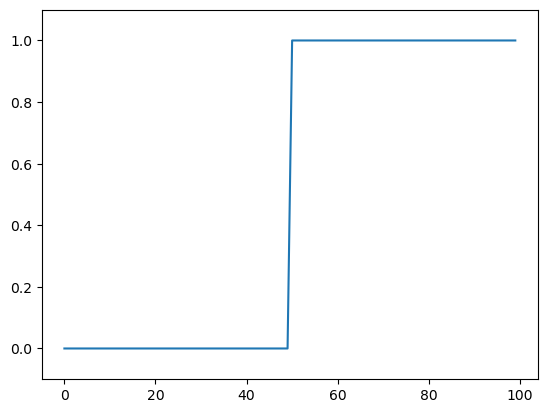

In [17]:
fig, ax = plt.subplots()
ax.plot(step_signal)
ax.margins(y=0.1) 

**Exercise:** Can you predict what a convolution with the kernel `[1, 0, -1]` does? Try thinking about it before running the cells below.

In [18]:
result_corr = np.convolve(step_signal, np.array([1, 0, -1]), mode='valid')

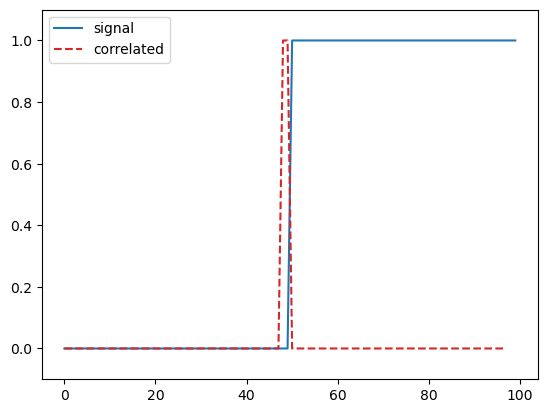

In [19]:
fig, ax = plt.subplots()
ax.plot(step_signal, label='signal')
ax.plot(result_corr, linestyle='dashed', label='correlated',
        color='C3')
ax.legend(loc='upper left')
ax.margins(y=0.1) 

(For technical signal processing reasons, convolutions actually occur "back to front" between the input array and the kernel. Correlations occur in the signal order.)

In [20]:
# equivalent code with np.correlate
result_corr = np.correlate(step_signal, np.array([-1, 0, 1]),
                           mode='valid')
                           # note that the kernel is [-1, 0, 1]

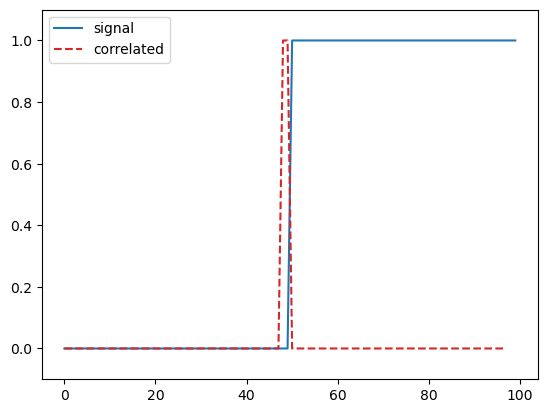

In [21]:
fig, ax = plt.subplots()
ax.plot(step_signal, label='signal')
ax.plot(result_corr, linestyle='dashed', label='correlated',
        color='C3')
ax.legend(loc='upper left')
ax.margins(y=0.1) 

Whenever neighboring values are close, the filter response is close to 0. Right at the boundary of a step, we're subtracting a small value from a large value and and get a spike in the response. This spike "identifies" our edge.

#### Commutativity and assortativity of filters

What if we try the same trick with our noisy signal?

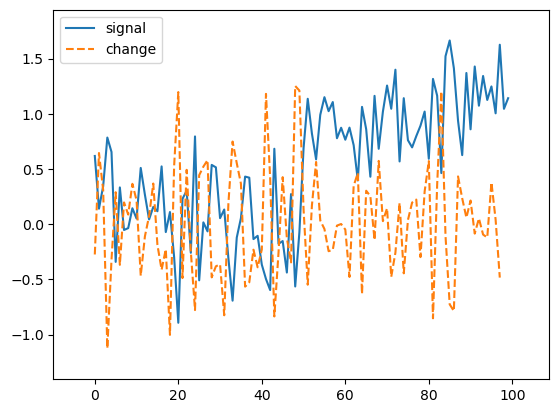

In [22]:
noisy_change = np.correlate(noisy_signal, np.array([-1, 0, 1]))
fig, ax = plt.subplots()
ax.plot(noisy_signal, label='signal')
ax.plot(noisy_change, linestyle='dashed', label='change')
ax.legend(loc='upper left')
ax.margins(0.1)

Oops! We lost our edge!

But recall that we smoothed the signal a bit by taking its neighbors. Perhaps we can do the same thing here. Actually, it turns out that we can do it *in any order*, so we can create a filter that combines both the difference and the mean:

In [23]:
mean_diff = np.correlate([-1, 0, 1], [1/3, 1/3, 1/3], mode='full')
print(mean_diff)

[-0.33333333 -0.33333333  0.          0.33333333  0.33333333]


Now we can use this to find our edge even in a noisy signal:

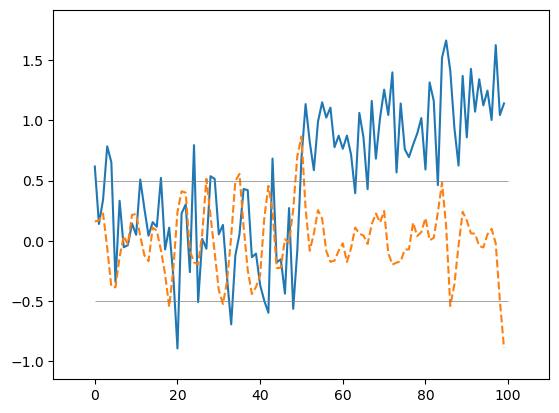

In [24]:
smooth_change = np.correlate(noisy_signal, mean_diff,
                             mode='same')
fig, ax = plt.subplots()
ax.plot(noisy_signal, label='signal')
ax.plot(smooth_change, linestyle='dashed', label='change')
ax.margins(0.1)
ax.hlines([-0.5, 0.5], 0, 100, linewidth=0.5, color='gray');

## 2D extension

Now let's apply all this knowledge to 2D images instead of a 1D signal. Let's start with an incredibly simple image:

In [25]:
import numpy as np

bright_square = np.zeros((7, 7), dtype=float)
bright_square[2:5, 2:5] = 1

This gives the values below:

In [26]:
print(bright_square)

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


and looks like a white square centered on a black square:

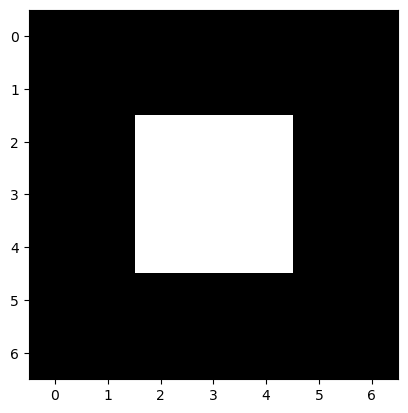

In [27]:
fig, ax = plt.subplots()
ax.imshow(bright_square);

### The mean filter

For our first example of a filter, consider the following filtering array, which we'll call a "mean kernel". For each pixel, a kernel defines which neighboring pixels to consider when filtering, and how much to weight those pixels.

In [28]:
mean_kernel = np.full((3, 3), 1/9)

print(mean_kernel)

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


Now, let's take our mean kernel and apply it to every pixel of the image.

Applying a (linear) filter essentially means:
* Center a kernel on a pixel
* Multiply the pixels *under* that kernel by the values *in* the kernel
* Sum all the those results
* Replace the center pixel with the summed result

This process is known as convolution.

Let's take a look at the numerical result:

In [29]:
import scipy.ndimage as ndi

%precision 2
print(bright_square)
print(ndi.correlate(bright_square, mean_kernel))

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
[[0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.11 0.22 0.33 0.22 0.11 0.  ]
 [0.   0.22 0.44 0.67 0.44 0.22 0.  ]
 [0.   0.33 0.67 1.   0.67 0.33 0.  ]
 [0.   0.22 0.44 0.67 0.44 0.22 0.  ]
 [0.   0.11 0.22 0.33 0.22 0.11 0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]]


The meaning of "mean kernel" should be clear now: Each pixel was replaced with the mean value within the 3x3 neighborhood of that pixel. When the kernel was over `n` bright pixels, the pixel in the kernel's center was changed to n/9 (= n * 0.111). When no bright pixels were under the kernel, the result was 0.

This filter is a simple smoothing filter and produces two important results:
1. The intensity of the bright pixel decreased.
2. The intensity of the region near the bright pixel increased.

Let's see a convolution in action.

(Execute the following cell, but don't try to read it; its purpose is to generate an example.)

In [30]:
#@title Visualization
#--------------------------------------------------------------------------
#  Convolution Demo
#--------------------------------------------------------------------------
from skimage import color
from scipy import ndimage as ndi
from matplotlib import patches

def mean_filter_demo(image, vmax=1):
    mean_factor = 1.0 / 9.0  # This assumes a 3x3 kernel.
    iter_kernel_and_subimage = iter_kernel(image)

    image_cache = []

    def mean_filter_step(i_step):
        while i_step >= len(image_cache):
            filtered = image if i_step == 0 else image_cache[-1][-1][-1]
            filtered = filtered.copy()

            (i, j), mask, subimage = next(iter_kernel_and_subimage)
            filter_overlay = color.label2rgb(mask, image, bg_label=0,
                                             colors=('cyan', 'red'))
            filtered[i, j] = np.sum(mean_factor * subimage)
            image_cache.append(((i, j), (filter_overlay, filtered)))

        (i, j), images = image_cache[i_step]
        fig, axes = plt.subplots(1, len(images), figsize=(10, 5))
        
        for ax, imc in zip(axes, images):
            ax.imshow(imc, vmax=vmax)
            rect = patches.Rectangle([j - 0.5, i - 0.5], 1, 1, color='yellow', fill=False)
            ax.add_patch(rect)
            
        plt.show()
    return mean_filter_step


def mean_filter_interactive_demo(image):
    from ipywidgets import IntSlider, interact
    mean_filter_step = mean_filter_demo(image)
    step_slider = IntSlider(min=0, max=image.size-1, value=0)
    interact(mean_filter_step, i_step=step_slider)


def iter_kernel(image, size=1):
    """ Yield position, kernel mask, and image for each pixel in the image.

    The kernel mask has a 2 at the center pixel and 1 around it. The actual
    width of the kernel is 2*size + 1.
    """
    width = 2*size + 1
    for (i, j), pixel in iter_pixels(image):
        mask = np.zeros(image.shape, dtype='int16')
        mask[i, j] = 1
        mask = ndi.grey_dilation(mask, size=width)
        #mask[i, j] = 2
        subimage = image[bounded_slice((i, j), image.shape[:2], size=size)]
        yield (i, j), mask, subimage


def iter_pixels(image):
    """ Yield pixel position (row, column) and pixel intensity. """
    height, width = image.shape[:2]
    for i in range(height):
        for j in range(width):
            yield (i, j), image[i, j]


def bounded_slice(center, xy_max, size=1, i_min=0):
    slices = []
    for i, i_max in zip(center, xy_max):
        slices.append(slice(max(i - size, i_min), min(i + size + 1, i_max)))
    return tuple(slices)



In [31]:
mean_filter_interactive_demo(bright_square)

interactive(children=(IntSlider(value=0, description='i_step', max=48), Output()), _dom_classes=('widget-inter…

Incidentally, the above filtering is the exact same principle behind the *convolutional neural networks*, or CNNs, that you might have heard much about over the past few years. The only difference is that while above, the simple mean kernel is used, in CNNs, the values inside the kernel are *learned* to find a specific feature, or accomplish a specific task. Time permitting, we'll demonstrate this in an exercise at the end of the notebook.

Slight aside:

In [32]:
print(np.sum(mean_kernel))

1.0


Note that all the values of the kernel sum to 1. Why might that be important?

In [33]:
# the following line will cause subsequent plotting commands to display directly in the notebook
%matplotlib inline

### Downsampled image

Let's consider a real image now. It'll be easier to see some of the filtering we're doing if we downsample the image a bit. We can slice into the image using the "step" argument to sub-sample it (don't scale images using this method for real work; use `skimage.transform.rescale`):

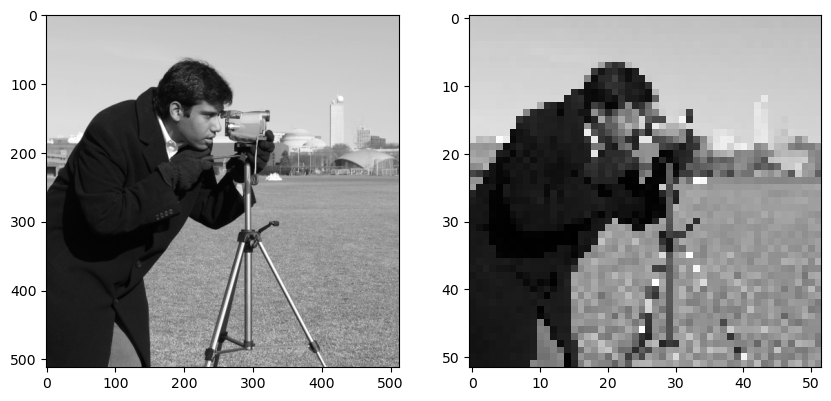

In [34]:
from skimage import data

image = data.camera()
pixelated = image[::10, ::10]
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
ax0.imshow(image)
ax1.imshow(pixelated);

Here we use a step of 10, giving us every tenth column and every tenth row of the original image. You can see the highly pixelated result on the right.

We are actually going to be using the pattern of plotting multiple images side by side quite often, so we are going to make the following helper function:

In [35]:
#@title just run this block
from skimage import img_as_float

def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 5
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,
                             figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax)
        ax.set_title(label)

### Mean filter on a real image

Now we can apply the filter to this downsampled image:

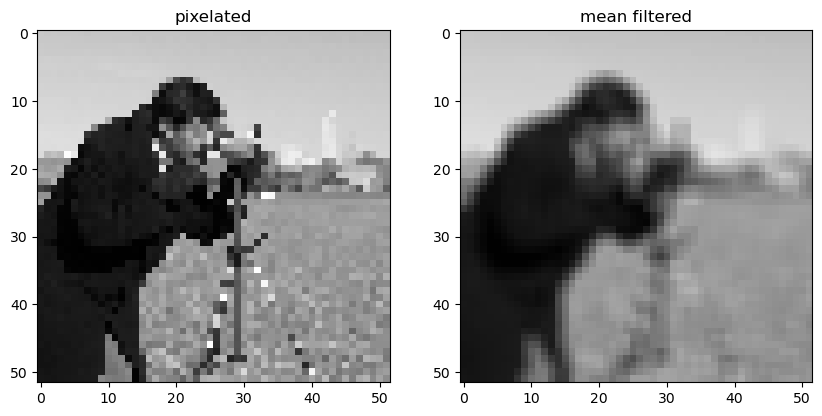

In [36]:
filtered = ndi.correlate(pixelated, mean_kernel)
imshow_all(pixelated, filtered, titles=['pixelated', 'mean filtered'])

Comparing the filtered image to the pixelated image, we can see that this filtered result is smoother: Sharp edges (which are just borders between dark and bright pixels) are smoothed because dark pixels reduce the intensity of neighboring pixels and bright pixels do the opposite.

If you read through the last section, you're already familiar with the essential concepts of image filtering. But, of course, you don't have to create custom filter kernels for all of your filtering needs. There are many standard filter kernels pre-defined from half a century of image and signal processing.

### Gaussian filter

The classic image filter is the Gaussian filter. This is similar to the mean filter, in that it tends to smooth images. The Gaussian filter, however, doesn't weight all values in the neighborhood equally. Instead, pixels closer to the center are weighted more than those farther away.

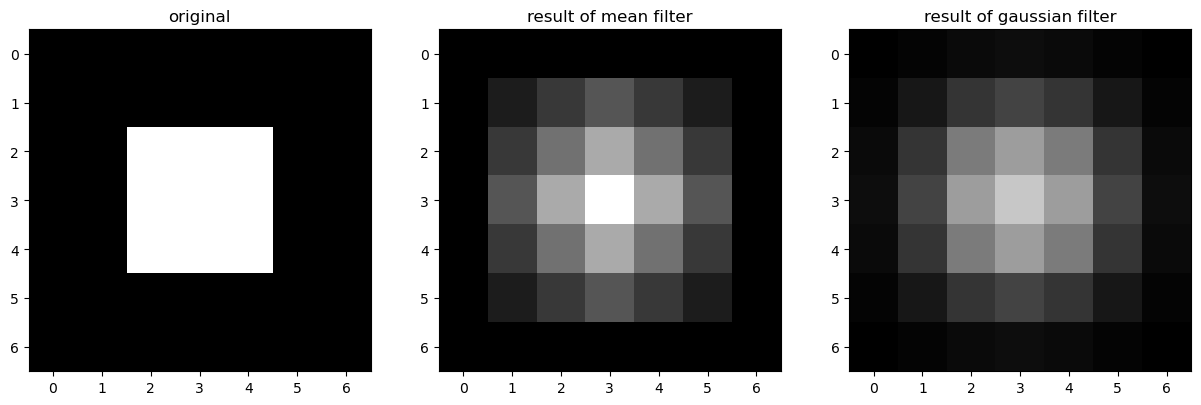

In [37]:
# Rename module so we don't shadow the builtin function
from skimage import filters

smooth_mean = ndi.correlate(bright_square, mean_kernel)
sigma = 1
smooth = filters.gaussian(bright_square, sigma)
imshow_all(bright_square, smooth_mean, smooth,
           titles=['original', 'result of mean filter', 'result of gaussian filter'])

For the Gaussian filter, `sigma`, the standard deviation, defines the size of the neighborhood.

For a real image, we get the following:

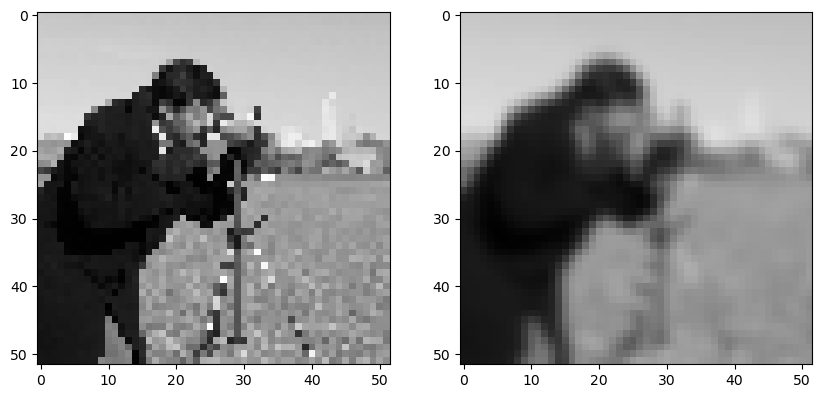

In [38]:
from skimage import img_as_float
# The Gaussian filter returns a float image, regardless of input.
# Cast to float so the images have comparable intensity ranges.
pixelated_float = img_as_float(pixelated)
smooth = filters.gaussian(pixelated_float, sigma=1)
imshow_all(pixelated_float, smooth)

This doesn't look drastically different than the mean filter, but the Gaussian filter is typically preferred because of the distance-dependent weighting, and because it does not have any sharp transitions (consider what happens in the Fourier domain!). For a more detailed image and a larger filter, you can see artifacts in the mean filter since it doesn't take distance into account:

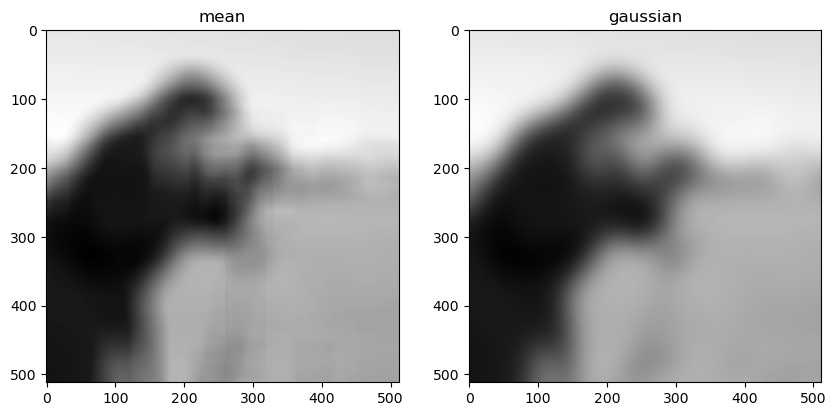

In [39]:
size = 20
structuring_element = np.ones((3*size, 3*size))
smooth_mean = filters.rank.mean(image, structuring_element)
smooth_gaussian = filters.gaussian(image, size)
titles = ['mean', 'gaussian']
imshow_all(smooth_mean, smooth_gaussian, titles=titles)

(Above, we've tweaked the size of the structuring element used for the mean filter and the standard deviation of the Gaussian filter to produce an approximately equal amount of smoothing in the two results.)

Incidentally, for reference, let's have a look at what the Gaussian filter actually looks like. Technically, the value of the kernel at a pixel that is $r$ rows and $c$ cols from the center is:

$$
k_{r, c} = \frac{1}{2\pi \sigma^2} \exp{\left(-\frac{r^2 + c^2}{2\sigma^2}\right)}
$$

Practically speaking, this value is pretty close to zero for values more than $4\sigma$ away from the center, so practical Gaussian filters are truncated at about $4\sigma$:

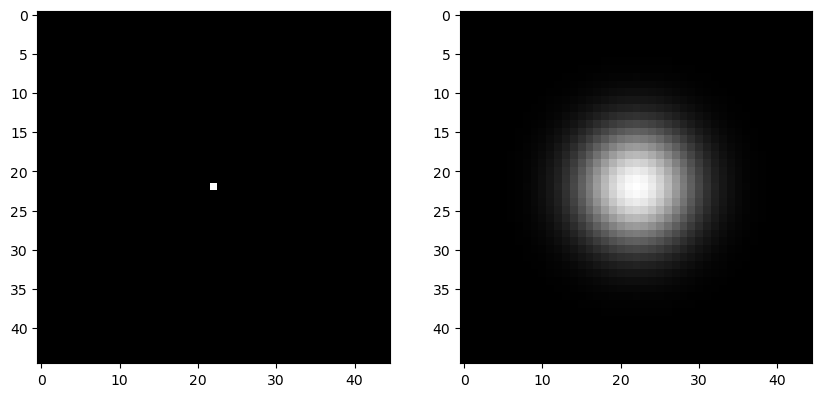

In [40]:
sidelen = 45
sigma = (sidelen - 1) // 2 // 4
spot = np.zeros((sidelen, sidelen), dtype=float)
spot[sidelen // 2, sidelen // 2] = 1
kernel = filters.gaussian(spot, sigma=sigma, truncate=4)

imshow_all(spot, kernel / np.max(kernel))

### ⏰ Exercise
Plot the profile of the gaussian kernel at its midpoint, i.e. the values under the line shown here:
Think about what you would expect to see.

(44.00, 0.00)

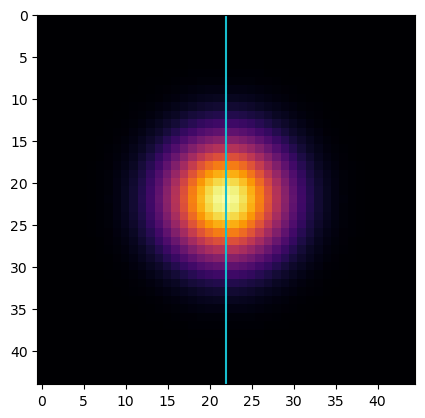

In [41]:
fig, ax = plt.subplots()

ax.imshow(kernel, cmap='inferno')
ax.vlines(22, -100, 100, color='C9')
ax.set_ylim((sidelen - 1, 0))

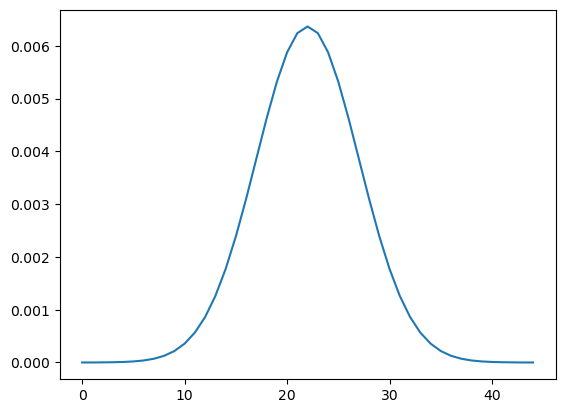

In [42]:
# add your plotting code here

midpoint = round(kernel.shape[1]/2)
kernel_mid = kernel[:, midpoint]
plt.plot(kernel_mid);

Did it match your expectations?

### ⏰Exercise: The Convolution Theorem
As we investigated have investigated, it is also possible to do convolutions using Fourier transforms, and in some cases this is the preferable method. In fact, there is some body of work investigating the use of ffts and multiplication to do convolution operations in convolutional neural networks. 

For this question, to illustrate this theorem, given a convolutional kernel you will find the corresponding Fourier operation that produces the same result. To this end,

1. create a 7x7 Gaussian kernel with a standard deviation $\sigma=2$ (using a pixel grid spacing of 1)
2. load an image, if it is color then convert it to grayscale (you can just sum the 3 color channels), and then resize the image into a 128x128 array
3. compute the convolution  - you can use a numpy (np) or scipy function. Make sure the output is the same size as the input image, which is slightly different than the formal definition of a discrete convolution, but is something that is usually convenient to do.
4. Find the Fourier filter that does the same operation in the Fourier domain, and show the resulting blurred image implemented using the Fourier method (i.e., if $I_{2}=I_{1}*h$, then $\mathcal{F}[I_{2}]=\mathcal{F}[I_{1}]\mathcal{F}[h]$, so find the correct array for $\mathcal{F}[h]$ and re-generate $I_2$). 

--2023-02-07 19:10:44--  https://1000logos.net/wp-content/uploads/2017/11/Duke-University-symbol.jpg
Resolving 1000logos.net (1000logos.net)... 172.67.71.45, 104.26.8.175, 104.26.9.175
Connecting to 1000logos.net (1000logos.net)|172.67.71.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 361044 (353K) [image/jpeg]
Saving to: 'Duke-University-symbol.jpg.22'

Duke-University-sym 100%[===================>] 352.58K  --.-KB/s    in 0.1s    

2023-02-07 19:10:45 (3.37 MB/s) - 'Duke-University-symbol.jpg.22' saved [361044/361044]



Text(0.5, 1.0, 'Convolved Image (through FFT)')

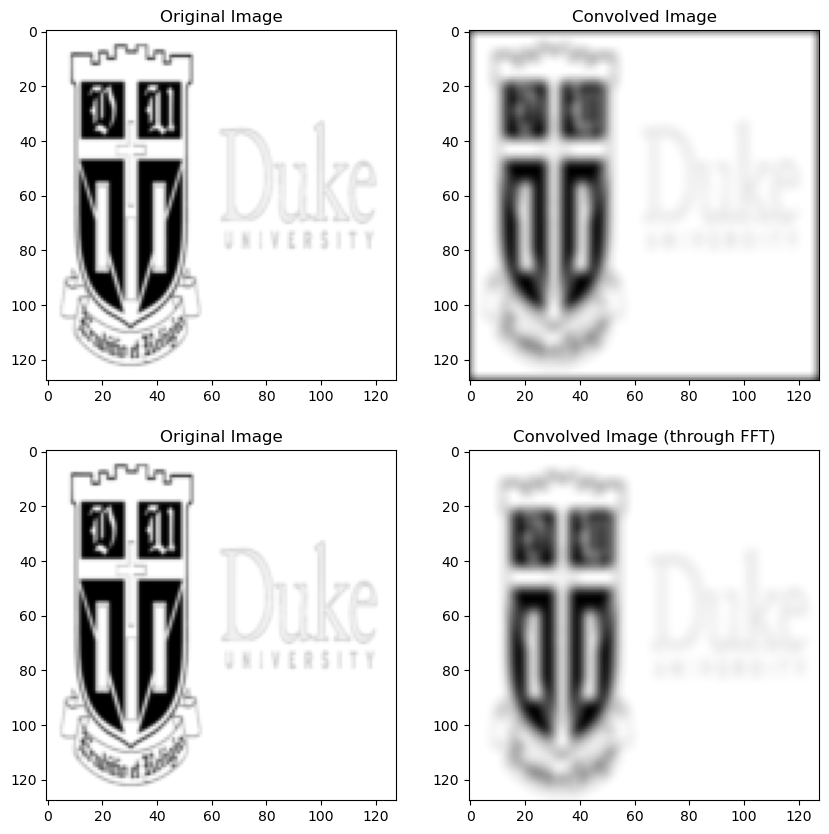

In [43]:
# your code here

import skimage
from scipy import signal
import scipy

# creating a 7 by 7 gaussian kernel
gaussian_kern1d = signal.gaussian(7, std=2)
gaussian_kern2d = np.outer(gaussian_kern1d, gaussian_kern1d)

# downloading a sample image
!wget https://1000logos.net/wp-content/uploads/2017/11/Duke-University-symbol.jpg

# reading the image
image = skimage.io.imread("Duke-University-symbol.jpg")

# converting the image to grayscale
image = image[:, :, 0] + image[:, :, 1] + image[:, :, 2]

#resizing the image to 128 by 128
resized_image = skimage.transform.resize(image, (128,128))

# convolving the image with the gaussian kernel
image_convolved = signal.convolve(resized_image, gaussian_kern2d, mode='same')

# computing the fft of the image and the gaussian kernel
resized_image_fft = scipy.fft.fft2(resized_image)
gaussian_kern2d_fft = scipy.fft.fft2(gaussian_kern2d, s=resized_image.shape)

# convolving the image with the gaussian kernel in the frequency domain
image_convolved_fft = resized_image_fft * gaussian_kern2d_fft

# computing the inverse fft of the convolved image
image_convolved_ifft = scipy.fft.ifft2(image_convolved_fft)

# plotting the results
fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax[0][0].imshow(resized_image)
ax[0][0].set_title("Original Image")
ax[0][1].imshow(image_convolved)
ax[0][1].set_title("Convolved Image")
ax[1][0].imshow(resized_image)
ax[1][0].set_title("Original Image")
ax[1][1].imshow(image_convolved_ifft.real)
ax[1][1].set_title("Convolved Image (through FFT)")

### Basic edge filtering

For images, edges are boundaries between light and dark values. The detection of edges can be useful on its own, or it can be used as preliminary step in other algorithms (which we'll see later).

#### Difference filters in 2D

For images, you can think of an edge as points where the gradient is large in one direction. We can approximate gradients with difference filters.

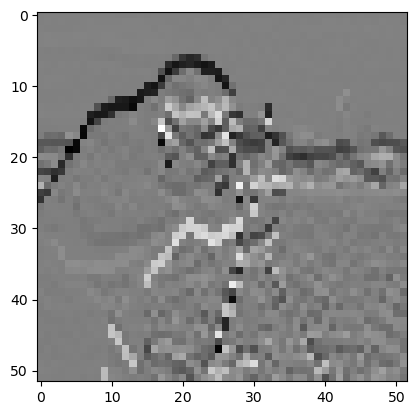

In [44]:
vertical_kernel = np.array([
    [-1],
    [ 0],
    [ 1],
])

gradient_vertical = ndi.correlate(pixelated.astype(float),
                                  vertical_kernel)
fig, ax = plt.subplots()
ax.imshow(gradient_vertical);

### ⏰ Exercise

- Add a horizontal kernel to the above example to also compute the horizontal gradient, $g_y$
- Compute the magnitude of the image gradient at each point: $\left|g\right| = \sqrt{g_x^2 + g_y^2}$

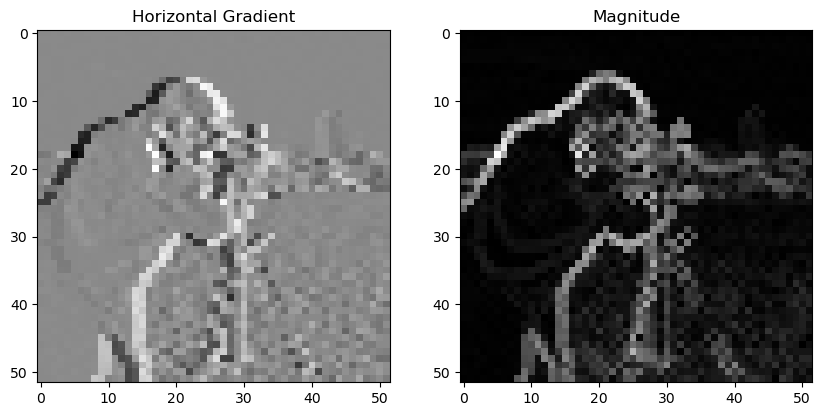

In [45]:
# add your horizontal and gradient magnitude code here

# creating the horizontal kernel
horizontal_kernel = vertical_kernel.T

# computing the horizontal gradient
gradient_horizontal = ndi.correlate(pixelated.astype(float), horizontal_kernel)

# computing the magnitude of the image gradient
magnitude = np.sqrt(gradient_horizontal**2 + gradient_vertical**2)

# plotting the results
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(gradient_horizontal)
ax[0].set_title("Horizontal Gradient")
ax[1].imshow(magnitude)
ax[1].set_title("Magnitude");

---

## Denoising filters

At this point, we make a distinction. The earlier filters were implemented as a *linear dot-product* of values in the filter kernel and values in the image. The following kernels implement an *arbitrary* function of the local image neighborhood. Denoising filters in particular are filters that preserve the sharpness of edges in the image.

As you can see from our earlier examples, mean and Gaussian filters smooth an image rather uniformly, including the edges of objects in an image. When denoising, however, you typically want to preserve features and just remove noise. The distinction between noise and features can, of course, be highly situation-dependent and subjective.

### Median Filter

The median filter is the classic edge-preserving filter. As the name implies, this filter takes a set of pixels (i.e. the pixels within a kernel or "structuring element") and returns the median value within that neighborhood. Because regions near a sharp edge will have many dark values and many light values (but few values in between) the median at an edge will most likely be either light or dark, rather than some value in between. In that way, we don't end up with edges that are smoothed.

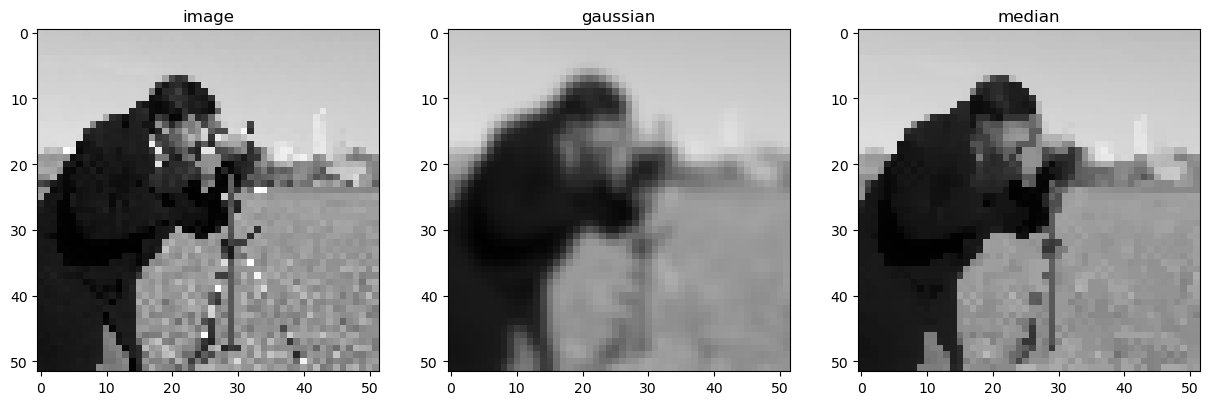

In [46]:
from skimage.morphology import disk
neighborhood = disk(radius=1)  # "selem" is often the name used for "structuring element"
median = filters.rank.median(pixelated, neighborhood)
titles = ['image', 'gaussian', 'median']
imshow_all(pixelated, smooth, median, titles=titles)

This difference is more noticeable with a more detailed image.

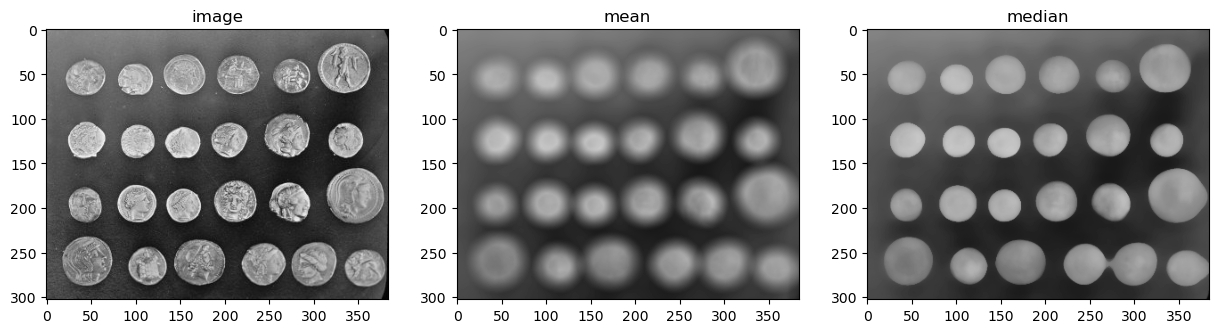

In [47]:
neighborhood = disk(10)
coins = data.coins()
mean_coin = filters.rank.mean(coins, neighborhood)
median_coin = filters.rank.median(coins, neighborhood)
titles = ['image', 'mean', 'median']
imshow_all(coins, mean_coin, median_coin, titles=titles)

Notice how the edges of coins are preserved after using the median filter.

**Median filters are not linear.** That means you cannot use a convolution to perform a median filter.

This non-linearity can sometimes be extremely useful. For example, if our image has pixels that are "dead" or have extremely large values, median filters can work really well.

For purpose of illustration, we can artificially create such an image using a skimage utility:

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io

image_stack = skimage.io.imread('https://github.com/guiwitz/PyImageCourse_beginner/raw/master/images/46658_784_B12_1.tif')
image_nuclei = image_stack[1250:1750,300:800,2]
image_noisy = skimage.util.random_noise(image_nuclei, mode='s&p')

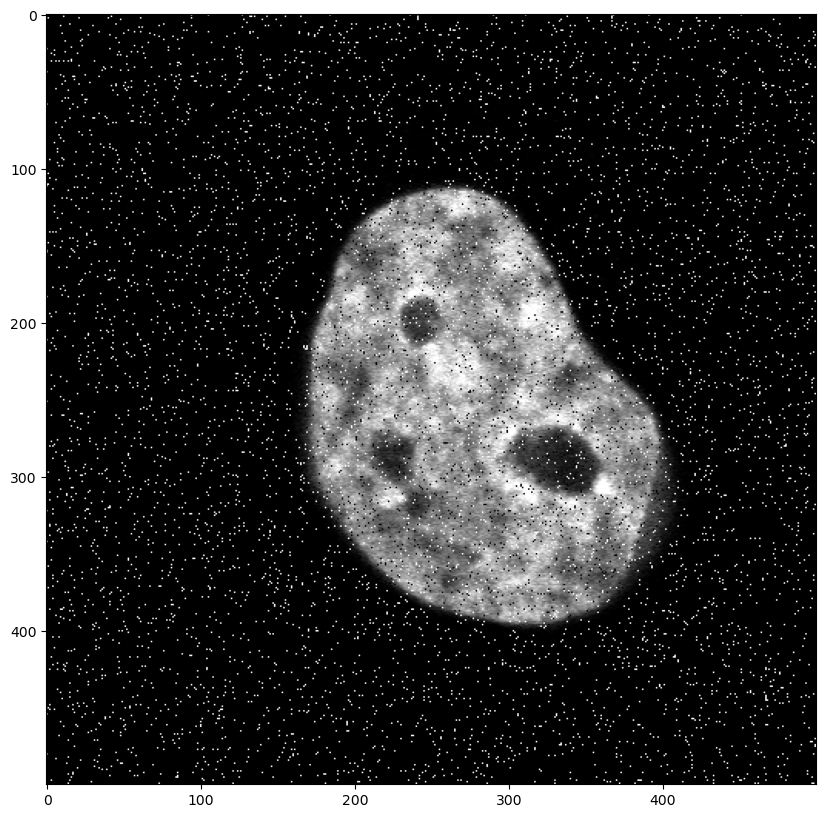

In [49]:
plt.subplots(figsize=(10,10))
plt.imshow(image_noisy, cmap = 'gray');

If we apply a median filter of size 3x3, pixels which are completely out of range are going to be replaced by the median value of their surroundings. The others, will be mildly affected:

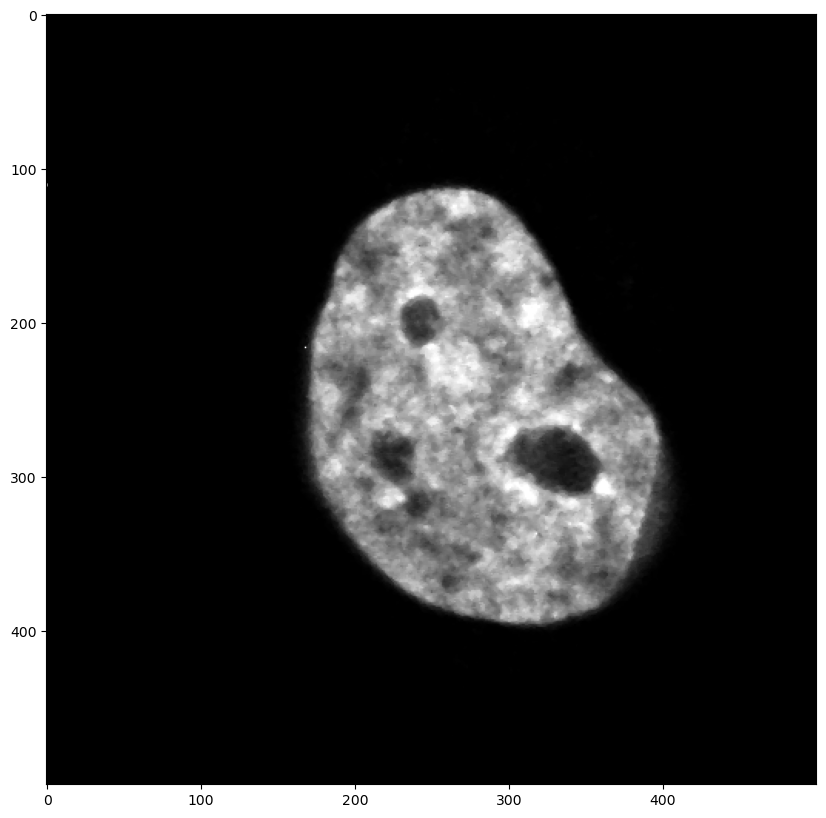

In [50]:
filtered_median = skimage.filters.median(image_noisy)

plt.subplots(figsize=(10,10))
plt.imshow(filtered_median, cmap = 'gray');

Image filtering is of course a ***vast*** topic, and you should read more about it if you need it in your work. These just a few examples to illustrate how to use filters in Python using scikit-image.

# Further reading
I am focusing the resources on use cases that might be helpful, either now or in the future. If you need help with the theory of image processing and filtering, you can talk to me. Duke also offers a number of good classes on image processing.

1. [Scikit-image gallery](https://scikit-image.org/docs/stable/auto_examples/index.html)
2. [Scikit-image user guide](https://scikit-image.org/docs/stable/user_guide.html)
3. Examples [here](http://justinbois.github.io/bootcamp/2022/lessons/l45_segmentation.html) and [here](http://justinbois.github.io/bootcamp/2022/lessons/l44_intro_to_image_processing.html) of bacterial cell segmentation
4. [A quick tour through scipy-lectures](https://scipy-lectures.org/packages/scikit-image/index.html)